In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 25)
pl.rc('legend', fontsize = 25)
sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
# ok, that doesn't tell me anything, lets see history of this, and then link with other stuff (SFR, los mass, that thing)

def getTemp(gal):
    
    z = []
    t95, t75, t50, t25, t5 = [], [], [], [], []

    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))

    
    for m in mtree:
        snap, idd = split_unique_id(int(m))
        
        VelGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][idd]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        
        # other way
        AllP = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][()]
        xi, yi, zi = AllP[:,0]-galPos[0], AllP[:,1]-galPos[1], AllP[:,2]-galPos[2]
        rr = np.sqrt(xi**2+yi**2+zi**2)
        inear = np.where(rr<100)[0]
        Loc = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(snap)][inear]
        ik = np.where(Loc==-1)[0]
        iknear = inear[ik]
        
        IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][iknear]
        Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][iknear]
        Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][iknear]
        ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][iknear]

        tTemp = tempFromMass(Mass, Abund, IE, ne1)
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

        tperC = np.percentile(tTemp, [95, 75, 50, 25, 5])
        
        #ok, i thing i got what i need.
        z.append(zs)
        
        t95.append(tperC[0])
        t75.append(tperC[1])
        t50.append(tperC[2])
        t25.append(tperC[3])
        t5.append(tperC[4])

    z = np.array(z)
    
    t95, t75, t50, t25, t5 = np.array(t95), np.array(t75), np.array(t50), np.array(t25), np.array(t5)
    return z, t95, t75, t50, t25, t5

In [7]:
z, t95, t75, t50, t25, t5 = getTemp(4338)

Text(0, 0.5, 'log(Temperature/K)')

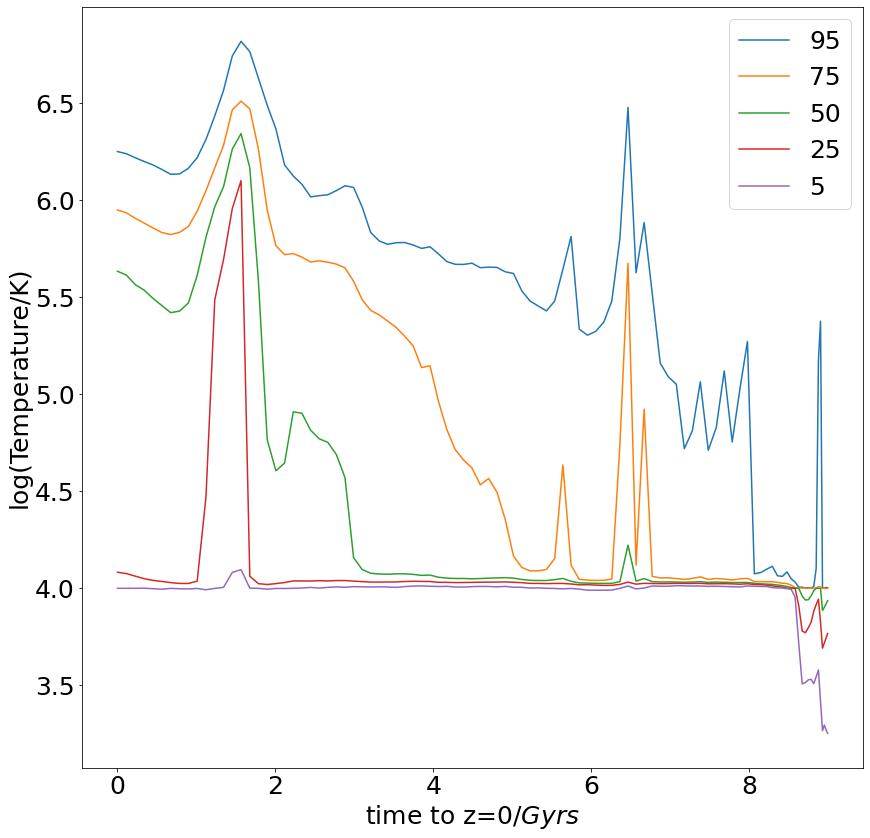

In [8]:
time = Cosmo.lookback_time(z).value

pl.figure(figsize=(14,14))

pl.plot(time, np.log10(t95), label='95')
pl.plot(time, np.log10(t75), label='75')
pl.plot(time, np.log10(t50), label='50')
pl.plot(time, np.log10(t25), label='25')
pl.plot(time, np.log10(t5), label='5')

pl.legend(loc='best')

pl.xlabel('time to z=0/$Gyrs$')
pl.ylabel('log(Temperature/K)')

In [9]:
z, t95, t75, t50, t25, t5 = getTemp(4474)

Text(0, 0.5, 'log(Temperature/K)')

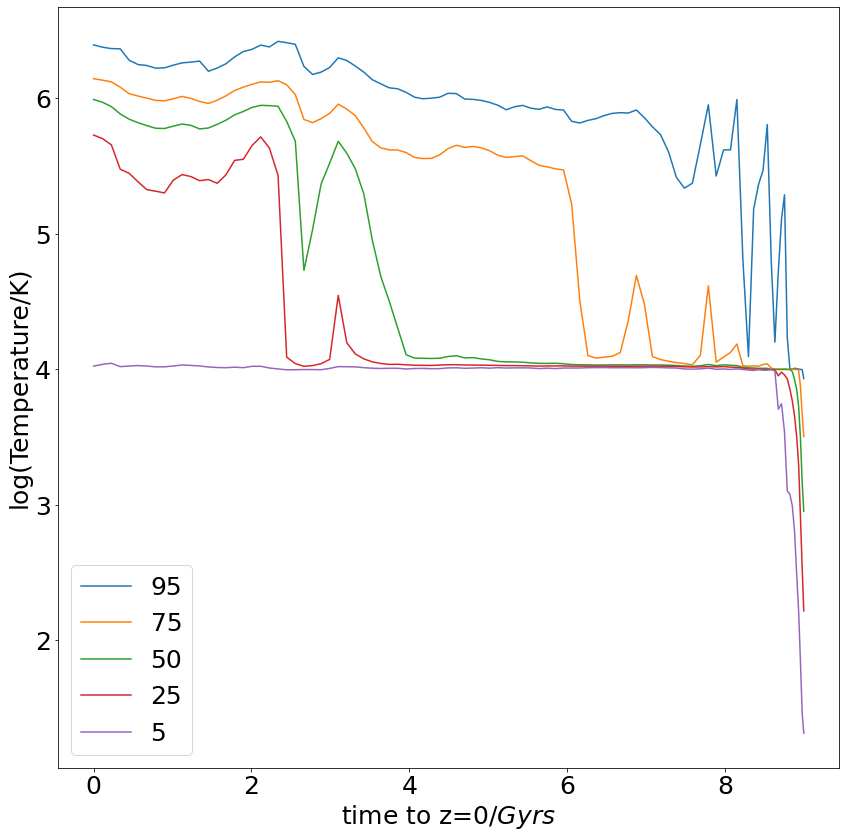

In [10]:
time = Cosmo.lookback_time(z).value

pl.figure(figsize=(14,14))

pl.plot(time, np.log10(t95), label='95')
pl.plot(time, np.log10(t75), label='75')
pl.plot(time, np.log10(t50), label='50')
pl.plot(time, np.log10(t25), label='25')
pl.plot(time, np.log10(t5), label='5')

pl.legend(loc='best')

pl.xlabel('time to z=0/$Gyrs$')
pl.ylabel('log(Temperature/K)')

In [11]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [12]:
# ok, lets calculate some ram pressures with only hot gas densities, this will be reduced a lot
Msun = 1.988*1e30
kpc = 3.086*1e16


def getSFRs(gal, central):
    
    RPS, z, SFR, snaplist, dist, RestForce = [], [], [], [], [], []
    GasMass, StarMass = [], []
    FeHL, OFeL = [], []
    
    Idlist, snapst  = [], []
    
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    z2, z1 = -1., -1.
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

#         OGas = sim['SnapNumber_{}/Groups/PartType0/Offsets'.format(snap)][group].astype('int')
#         Densities = sim['SnapNumber_{}/PartType0/Density'.format(snap)][OGas[0]:OGas[1]]
#         Positions = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OGas[0]:OGas[1]]

#         Loc = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(snap)][OGas[0]:OGas[1]]

#         i = np.where(Loc==-1)

#         Densities = Densities[i]
#         Positions = Positions[i]
        
#         X, Y, Z = Positions[:,0] - groupPos[0], Positions[:,1] - groupPos[1], Positions[:,2] - groupPos[2]
#         R = np.sqrt(X**2+Y**2+Z**2)/r200

#         rmed1, redges, rbins = sp.binned_statistic(R, Densities*1e10, statistic='median', bins=20, range=(0, 5))
#         rx = 0.5*(redges[:-1]+redges[1:])
        
#         i = np.where(np.isnan(rmed1)==True)
#         rmed1[i] = 0.

#         GroupDens = rmed1*Msun/(kpc**3.)
        
        # ok, lets measure the ram pressure

        VelCen = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][iddC]
        VelGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][idd]

        #Vel = np.sqrt(np.sum((VelGal - VelCen)**2.))*1e3 # in m/s

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

        pos = np.sqrt(np.sum((galPos-groupPos)**2))/r200
        
#         DensGal = np.interp(pos, rx, GroupDens)

#         rpsEst = DensGal*Vel**2.
        
        # other way
        AllP = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][()]
        xi, yi, zi = AllP[:,0]-galPos[0], AllP[:,1]-galPos[1], AllP[:,2]-galPos[2]
        rr = np.sqrt(xi**2+yi**2+zi**2)
        inear = np.where(rr<100)[0]
        Loc = sim['SnapNumber_{}/PartType0/SubGroupNumber'.format(snap)][inear]
        ik = np.where(Loc==-1)[0]
        iknear = inear[ik]
        #Densities = sim['SnapNumber_{}/PartType0/Density'.format(snap)][iknear]
        
        IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][iknear]
        Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][iknear]
        Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][iknear]
        ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][iknear]

        tTemp = tempFromMass(Mass, Abund, IE, ne1)
        iT = np.where(tTemp>1e6)[0]
        ikTnear = iknear[iT]
        NoMasses = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][ikTnear]
        Vol = 3/.4*np.pi*100**3.
        Densities = np.sum(NoMasses)*1e10/Vol
        
        DensGal = Densities*Msun/(kpc**3.)
        
        VGas = sim['SnapNumber_{}/PartType0/Velocities'.format(snap)][iknear]
        VGas = VGas[iT]
        try:
            xVg, yVg, zVg = np.average(VGas[:,0], weights=NoMasses), np.average(VGas[:,1], weights=NoMasses), np.average(VGas[:,2], weights=NoMasses)
        except ZeroDivisionError:
            xVg, yVg, zVg = 0., 0., 0. # whatever
        VelGas = np.array([xVg, yVg, zVg])
        Vel = np.sqrt(np.sum((VelGal - VelGas)**2.))*1e3 # in m/s
        
        rpsEst = DensGal*Vel**2.
        
        GasOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        StarOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')

        gaspos = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][GasOff[0]:GasOff[1]]
        starpos = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][StarOff[0]:StarOff[1]]

        nindgas = np.array(range(GasOff[0], GasOff[1]))
        nindstars = np.array(range(StarOff[0], StarOff[1]))

        xg, yg, zg = gaspos[:,0]-galPos[0], gaspos[:,1]-galPos[1], gaspos[:,2]-galPos[2]
        xs, ys, zs = starpos[:,0]-galPos[0], starpos[:,1]-galPos[1], starpos[:,2]-galPos[2]

        rg = np.sqrt(xg**2+yg**2+zg**2)
        rs = np.sqrt(xs**2+ys**2+zs**2)

        rad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        ig = np.where(rg<=rad)[0]
        iss = np.where(rs<=rad)[0]

        naregas = nindgas[ig]
        narestars = nindstars[iss]

        Area = np.pi*rad**2.

        MassGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][naregas]
        MassStars = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][narestars]

        SigmaGas = np.sum(MassGas)*1e10/Area
        SigmaStars = np.sum(MassStars)*1e10/Area

        G = 4.3*1e-6 # kpc/M_sun km^2/s^2

        Rest = 2*np.pi*G*SigmaGas*SigmaStars
        RestU = Rest*1e3*Msun/(kpc**3)
        
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        
        sfr = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][offgal[0]:offgal[1]]
        massGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][offgal[0]:offgal[1]]
        PosPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offgal[0]:offgal[1]]
        OptRad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        
        xTc, yTc, zTc = PosPart[:,0]-galPos[0], PosPart[:,1]-galPos[1], PosPart[:,2]-galPos[2]
        distT = np.sqrt(xTc**2.+yTc**2.+zTc**2.)
        icoun = np.where(distT<=OptRad)[0]
        
        TSFR = np.sum(sfr[icoun])
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        if pos<2.:
            z2 = zs
        if pos<1.:
            z1 = zs
        
        #ok, i thing i got what i need.
        Abund2 = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][offgal[0]:offgal[1]]
        TFeH = np.log10((Abund2[:,4]/FeMass)/(Abund2[:,6]/HMass)) - NfeNhe_sun
        TOFe = np.log10((Abund2[:,3]/OMass)/(Abund2[:,4]/FeMass)) - NoNfe_sun

        FeHL.extend(list(TFeH))
        OFeL.extend(list(TOFe))
        
#         RPS.append(rpsEst/RestU)
        RPS.append(rpsEst)
        RestForce.append(RestU)
        z.append(zs)
        SFR.append(TSFR)
        snaplist.append(snap)
        dist.append(pos)
        GasMass.append(np.sum(MassGas)*1e10)
        StarMass.append(np.sum(MassStars)*1e10)
    
        # and now lost masses
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        
    RPS, z, SFR, snaplist, dist = np.array(RPS), np.array(z), np.array(SFR), np.array(snaplist), np.array(dist)
    RestForce = np.array(RestForce)
    FeHL, OFeL = np.array(FeHL), np.array(OFeL)
    
    GasMass = np.array(GasMass)
    StarMass = np.array(StarMass)
    
    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    FeHL, OFeL = FeHL[Idunique], OFeL[Idunique]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    # and mets
    
    FeHL_ = FeHL[iidex_]
    OFeL_ = OFeL[iidex]
    
    FeHLorder = np.zeros(IndexT_.size)
    OFeLorder = np.zeros(IndexT_.size)
    
    FeHLorder[is1] = FeHL_[is2]
    OFeLorder[is1] = OFeL_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    FeHlo, OFelo = [], []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
        FeHt = FeHLorder[k]
        OFet = OFeLorder[k]
        iF = np.where((np.isnan(FeHt)==False) & (np.isinf(FeHt)==False))
        iO = np.where((np.isnan(OFet)==False) & (np.isinf(OFet)==False))
        FeHlo.append(np.median(FeHt[iF]))
        OFelo.append(np.median(OFet[iF]))
        
    
    Gas = np.array(Gas)
    FeHlo, OFelo = np.array(FeHlo), np.array(OFelo)
    return RPS, z, SFR, dist, RestForce, Gas*1e10, z1, z2, GasMass, StarMass, FeHlo, OFelo

In [13]:
# ok, lets test this
RPSC_4470, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass, FeHlo, OFelo = getSFRs(4470, 4469)

it = np.where(RPSC_4470>0.)
RPSC_4470, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPSC_4470[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]
FeHlo, OFelo = FeHlo[it], OFelo[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
RPSC_4471, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass, FeHlo, OFelo = getSFRs(4471, 4469)

it = np.where(RPSC_4471>0.)
RPSC_4471, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPSC_4471[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]
FeHlo, OFelo = FeHlo[it], OFelo[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide


In [15]:
RPSC_4473, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass, FeHlo, OFelo = getSFRs(4473, 4469)

it = np.where(RPSC_4473>0.)
RPSC_4473, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPSC_4473[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]
FeHlo, OFelo = FeHlo[it], OFelo[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide


In [16]:
RPSC_4474, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass, FeHlo, OFelo = getSFRs(4474, 4469)

it = np.where(RPSC_4471>0.)
RPSC_4474, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPSC_4474[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]
FeHlo, OFelo = FeHlo[it], OFelo[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in less_equal


In [17]:
RPSC_4338, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass, FeHlo, OFelo = getSFRs(4338, 4337)

it = np.where(RPSC_4338>0.)
RPSC_4338, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPSC_4338[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]
FeHlo, OFelo = FeHlo[it], OFelo[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide


In [18]:
RPSC_4339, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass, FeHlo, OFelo = getSFRs(4339, 4337)

it = np.where(RPSC_4339>0.)
RPSC_4339, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPSC_4339[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]
FeHlo, OFelo = FeHlo[it], OFelo[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide


In [19]:
RPSC_4341, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass, FeHlo, OFelo = getSFRs(4341, 4337)

it = np.where(RPSC_4341>0.)
RPSC_4341, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPSC_4341[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]
FeHlo, OFelo = FeHlo[it], OFelo[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in less_equal


In [20]:
RPSC_4343, z, SFR, dist, RestForce, Gas, z1, z2, gasMass, starMass, FeHlo, OFelo = getSFRs(4343, 4337)

it = np.where(RPSC_4343>0.)
RPSC_4343, z, SFR, dist, Gas, RestForce, gasMass, starMass = RPSC_4343[it], z[it], SFR[it], dist[it], Gas[it], RestForce[it], gasMass[it], starMass[it]
FeHlo, OFelo = FeHlo[it], OFelo[it]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in less_equal
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in less_equal


In [21]:
# I want to look at something, so lets read the thing:

T = h5py.File('Derived_Data.h5', 'r')


dist_4338 = T['g4338/distance'][()]
Time_4338 = T['g4338/time'][()]
cosC_4338 = T['g4338/CosCen'][()]
cosV_4338 = T['g4338/CosVel'][()]
RP_4338 = T['g4338/RP'][()]
TSt_4338 = T['g4338/TSt'][()]
gMass_4338 = T['g4338/gMass'][()]
SFR_4338 = T['g4338/SFR'][()]
starMass_4338 = T['g4338/starMass'][()]
Gas_4338 = T['g4338/Gas'][()]
RestForce_4338 = T['g4338/RestForce'][()]

dist_4339 = T['g4339/distance'][()]
Time_4339 = T['g4339/time'][()]
cosC_4339 = T['g4339/CosCen'][()]
cosV_4339 = T['g4339/CosVel'][()]
RP_4339 = T['g4339/RP'][()]
TSt_4339 = T['g4339/TSt'][()]
gMass_4339 = T['g4339/gMass'][()]
SFR_4339 = T['g4339/SFR'][()]
starMass_4339 = T['g4339/starMass'][()]
Gas_4339 = T['g4339/Gas'][()]
RestForce_4339 = T['g4339/RestForce'][()]

dist_4341 = T['g4341/distance'][()]
Time_4341 = T['g4341/time'][()]
cosC_4341 = T['g4341/CosCen'][()]
cosV_4341 = T['g4341/CosVel'][()]
RP_4341 = T['g4341/RP'][()]
TSt_4341 = T['g4341/TSt'][()]
gMass_4341 = T['g4341/gMass'][()]
SFR_4341 = T['g4341/SFR'][()]
starMass_4341 = T['g4341/starMass'][()]
Gas_4341 = T['g4341/Gas'][()]
RestForce_4341 = T['g4341/RestForce'][()]

dist_4343 = T['g4343/distance'][()]
Time_4343 = T['g4343/time'][()]
cosC_4343 = T['g4343/CosCen'][()]
cosV_4343 = T['g4343/CosVel'][()]
RP_4343 = T['g4343/RP'][()]
TSt_4343 = T['g4343/TSt'][()]
gMass_4343 = T['g4343/gMass'][()]
SFR_4343 = T['g4343/SFR'][()]
starMass_4343 = T['g4343/starMass'][()]
Gas_4343 = T['g4343/Gas'][()]
RestForce_4343 = T['g4343/RestForce'][()]

dist_4470 = T['g4470/distance'][()]
Time_4470 = T['g4470/time'][()]
cosC_4470 = T['g4470/CosCen'][()]
cosV_4470 = T['g4470/CosVel'][()]
RP_4470 = T['g4470/RP'][()]
TSt_4470 = T['g4470/TSt'][()]
gMass_4470 = T['g4470/gMass'][()]
SFR_4470 = T['g4470/SFR'][()]
starMass_4470 = T['g4470/starMass'][()]
Gas_4470 = T['g4470/Gas'][()]
RestForce_4470 = T['g4470/RestForce'][()]

dist_4471 = T['g4471/distance'][()]
Time_4471 = T['g4471/time'][()]
cosC_4471 = T['g4471/CosCen'][()]
cosV_4471 = T['g4471/CosVel'][()]
RP_4471 = T['g4471/RP'][()]
TSt_4471 = T['g4471/TSt'][()]
gMass_4471 = T['g4471/gMass'][()]
SFR_4471 = T['g4471/SFR'][()]
starMass_4471 = T['g4471/starMass'][()]
Gas_4471 = T['g4471/Gas'][()]
RestForce_4471 = T['g4471/RestForce'][()]

dist_4473 = T['g4473/distance'][()]
Time_4473 = T['g4473/time'][()]
cosC_4473 = T['g4473/CosCen'][()]
cosV_4473 = T['g4473/CosVel'][()]
RP_4473 = T['g4473/RP'][()]
TSt_4473 = T['g4473/TSt'][()]
gMass_4473 = T['g4473/gMass'][()]
SFR_4473 = T['g4473/SFR'][()]
starMass_4473 = T['g4473/starMass'][()]
Gas_4473 = T['g4473/Gas'][()]
RestForce_4473 = T['g4473/RestForce'][()]

dist_4474 = T['g4474/distance'][()]
Time_4474 = T['g4474/time'][()]
cosC_4474 = T['g4474/CosCen'][()]
cosV_4474 = T['g4474/CosVel'][()]
RP_4474 = T['g4474/RP'][()]
TSt_4474 = T['g4474/TSt'][()]
gMass_4474 = T['g4474/gMass'][()]
SFR_4474 = T['g4474/SFR'][()]
starMass_4474 = T['g4474/starMass'][()]
Gas_4474 = T['g4474/Gas'][()]
RestForce_4474 = T['g4474/RestForce'][()]

In [22]:
RP_4338.size, RPSC_4338.size

(25, 85)

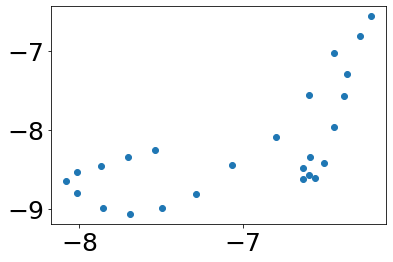

In [23]:
pl.plot(np.log10(RP_4338), np.log10(RPSC_4338[:RP_4338.size]), marker='o', ls=' ')

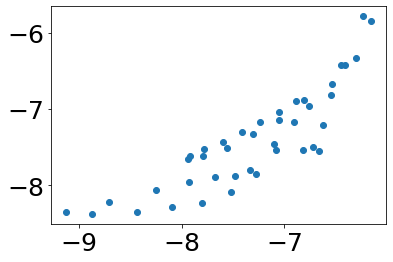

In [24]:
pl.plot(np.log10(RP_4339), np.log10(RPSC_4339[:RP_4339.size]), marker='o', ls=' ')

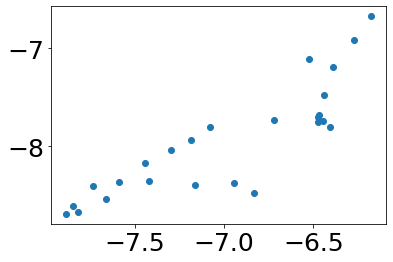

In [25]:
pl.plot(np.log10(RP_4341), np.log10(RPSC_4341[:RP_4341.size]), marker='o', ls=' ')

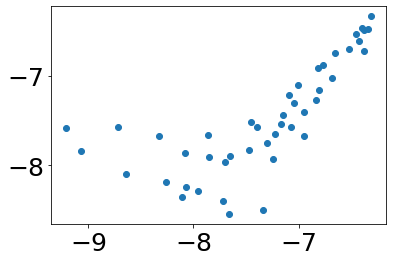

In [26]:
pl.plot(np.log10(RP_4343), np.log10(RPSC_4343[:RP_4343.size]), marker='o', ls=' ')

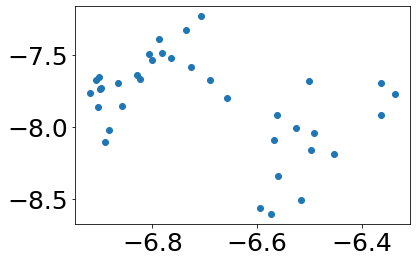

In [27]:
pl.plot(np.log10(RP_4470), np.log10(RPSC_4470[:RP_4470.size]), marker='o', ls=' ')

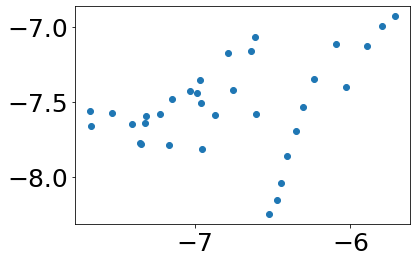

In [28]:
pl.plot(np.log10(RP_4471), np.log10(RPSC_4471[:RP_4471.size]), marker='o', ls=' ')

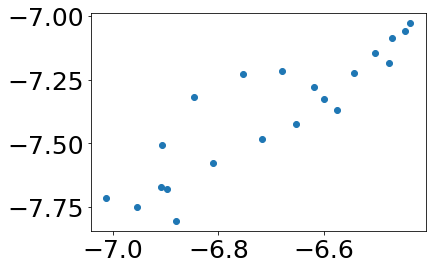

In [29]:
pl.plot(np.log10(RP_4473), np.log10(RPSC_4473[:RP_4473.size]), marker='o', ls=' ')

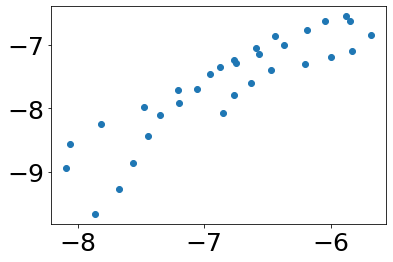

In [30]:
pl.plot(np.log10(RP_4474), np.log10(RPSC_4474[:RP_4474.size]), marker='o', ls=' ')

Text(0.5, 0, 'Time/Gyrs h$^{-1}$')

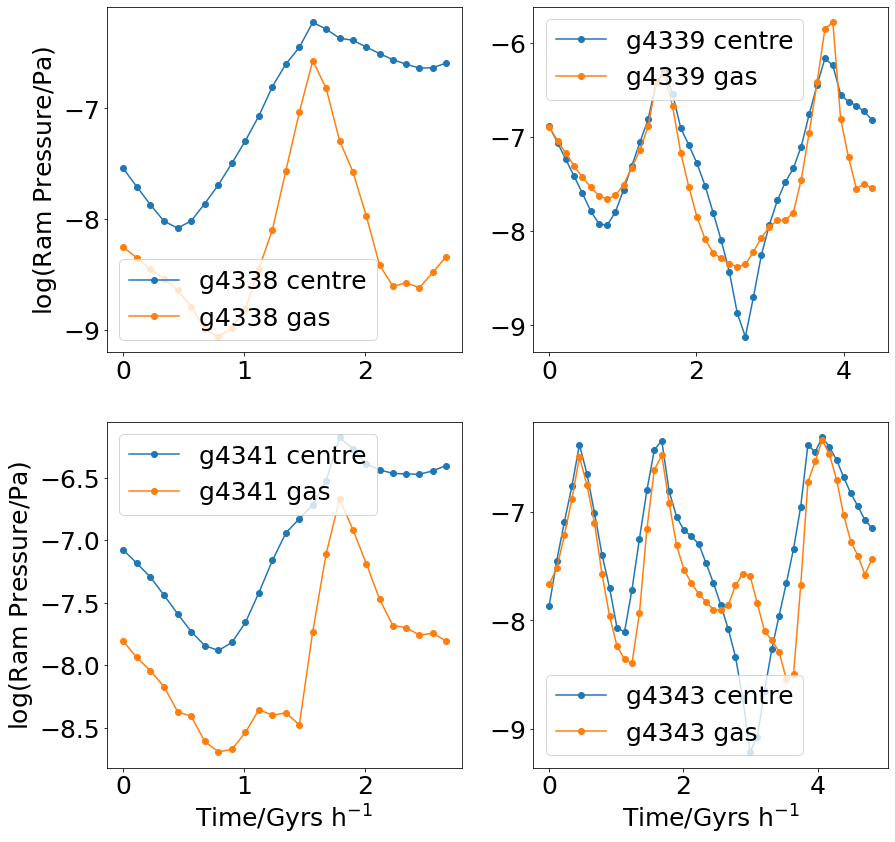

In [31]:
pl.figure(figsize=(14,14))

pl.subplot(2, 2, 1)

pl.plot(Time_4338, np.log10(RP_4338), ls='-', marker='o', label='g4338 centre')
pl.plot(Time_4338, np.log10(RPSC_4338[:RP_4338.size]), ls='-', marker='o', label='g4338 gas')

pl.legend(loc='best')

pl.ylabel('$\log($Ram Pressure/Pa)')
# pl.xlabel('Time/Gyrs h$^{-1}$')

pl.subplot(2, 2, 2)

pl.plot(Time_4339, np.log10(RP_4339), ls='-', marker='o', label='g4339 centre')
pl.plot(Time_4339, np.log10(RPSC_4339[:RP_4339.size]), ls='-', marker='o', label='g4339 gas')

pl.legend(loc='best')

# pl.ylabel('$\log($Ram Pressure/Pa)')
# pl.xlabel('Time/Gyrs h$^{-1}$')

pl.subplot(2, 2, 3)

pl.plot(Time_4341, np.log10(RP_4341), ls='-', marker='o', label='g4341 centre')
pl.plot(Time_4341, np.log10(RPSC_4341[:RP_4341.size]), ls='-', marker='o', label='g4341 gas')

pl.legend(loc='best')

pl.ylabel('$\log($Ram Pressure/Pa)')
pl.xlabel('Time/Gyrs h$^{-1}$')

pl.subplot(2, 2, 4)

pl.plot(Time_4343, np.log10(RP_4343), ls='-', marker='o', label='g4343 centre')
pl.plot(Time_4343, np.log10(RPSC_4343[:RP_4343.size]), ls='-', marker='o', label='g4343 gas')

pl.legend(loc='best')

# pl.ylabel('$\log($Ram Pressure/Pa)')
pl.xlabel('Time/Gyrs h$^{-1}$')

Text(0.5, 0, 'Time/Gyrs h$^{-1}$')

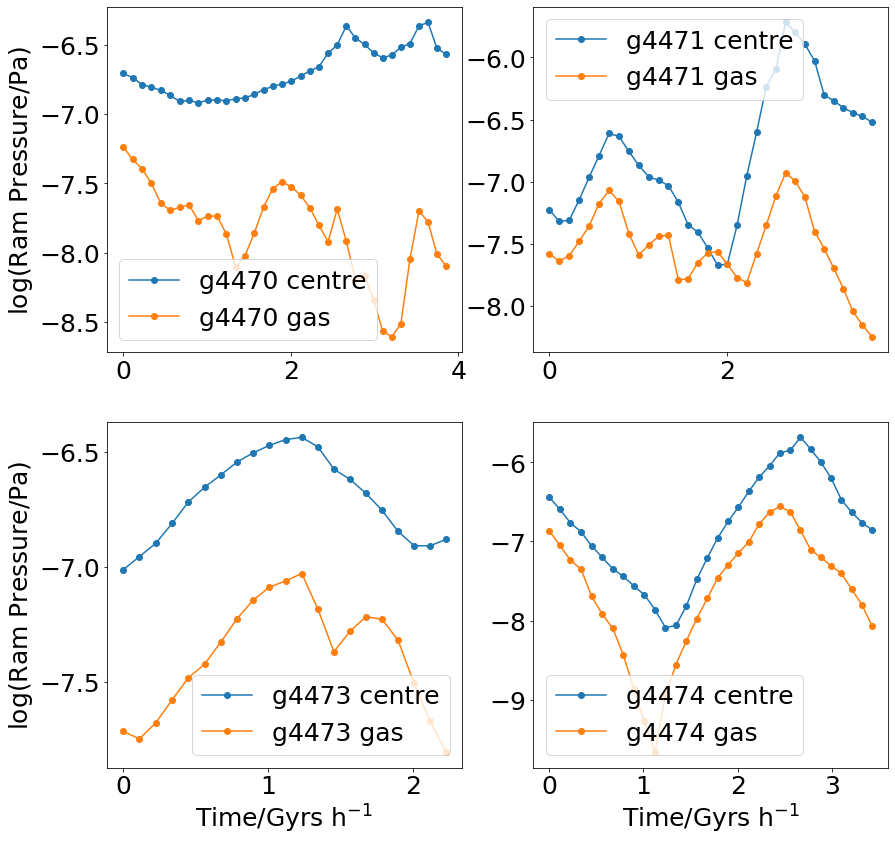

In [32]:
pl.figure(figsize=(14,14))

pl.subplot(2, 2, 1)

pl.plot(Time_4470, np.log10(RP_4470), ls='-', marker='o', label='g4470 centre')
pl.plot(Time_4470, np.log10(RPSC_4470[:RP_4470.size]), ls='-', marker='o', label='g4470 gas')

pl.legend(loc='best')

pl.ylabel('$\log($Ram Pressure/Pa)')
# pl.xlabel('Time/Gyrs h$^{-1}$')

pl.subplot(2, 2, 2)

pl.plot(Time_4471, np.log10(RP_4471), ls='-', marker='o', label='g4471 centre')
pl.plot(Time_4471, np.log10(RPSC_4471[:RP_4471.size]), ls='-', marker='o', label='g4471 gas')

pl.legend(loc='best')

# pl.ylabel('$\log($Ram Pressure/Pa)')
# pl.xlabel('Time/Gyrs h$^{-1}$')

pl.subplot(2, 2, 3)

pl.plot(Time_4473, np.log10(RP_4473), ls='-', marker='o', label='g4473 centre')
pl.plot(Time_4473, np.log10(RPSC_4473[:RP_4473.size]), ls='-', marker='o', label='g4473 gas')

pl.legend(loc='best')

pl.ylabel('$\log($Ram Pressure/Pa)')
pl.xlabel('Time/Gyrs h$^{-1}$')

pl.subplot(2, 2, 4)

pl.plot(Time_4474, np.log10(RP_4474), ls='-', marker='o', label='g4474 centre')
pl.plot(Time_4474, np.log10(RPSC_4474[:RP_4474.size]), ls='-', marker='o', label='g4474 gas')

pl.legend(loc='best')

# pl.ylabel('$\log($Ram Pressure/Pa)')
pl.xlabel('Time/Gyrs h$^{-1}$')